# Traditional ML Algorithms

In [2]:
import os
from scipy.sparse import load_npz
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing
import pickle

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelBinarizer

from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, auc, roc_curve, RocCurveDisplay, confusion_matrix, classification_report
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle

DATASET_COLUMNS = ['Id', 'Review', 'Sentiment']
senti_labels = {1: 'Negative', 2: 'Neutral', 3: 'Positive'}
senti_categories = list(senti_labels.values())
NUM_of_CLASSES = 3

input_folder_path = "./pls/Thesis_Jupyter_Final/src/input/"
processed_folder_path = "./pls/Thesis_Jupyter_Final/src/input/processed"

In [3]:
train = pd.read_csv(os.path.join(input_folder_path, "train.csv"))
val = pd.read_csv(os.path.join(input_folder_path, "val.csv"))
test = pd.read_csv(os.path.join(input_folder_path, "test.csv"))

#x_train = pd.read_csv(os.path.join(processed_folder_path, "train_tfidf.csv"))
y_train = train['y']
#x_val = pd.read_csv(os.path.join(processed_folder_path, "val_tfidf.csv"))
y_val = val['y']
#x_test = pd.read_csv(os.path.join(processed_folder_path, "test_tfidf.csv"))
y_test = test['y']

x_train = load_npz(os.path.join(processed_folder_path, "train_tfidf.npz"))
x_val = load_npz(os.path.join(processed_folder_path, "val_tfidf.npz"))
x_test = load_npz(os.path.join(processed_folder_path, "test_tfidf.npz"))



%store -r tfidf_vectorizer
print(tfidf_vectorizer)

TfidfVectorizer(lowercase=False, max_df=0.95, max_features=10000, min_df=5,
                sublinear_tf=True,
                vocabulary={'.': 3749, ':(': 2449, ':(_NEG': 3378, ':)': 1092,
                            ':)_NEG': 1712, ':-)': 2620, ':-)_NEG': 2965,
                            ':d': 283, ';)': 3910, ';)_NEG': 518, ';-)': 1362,
                            '<3': 2611, '=)': 3462, 'ability': 154,
                            'ability_NEG': 2317, 'able': 159, 'able_NEG': 2173,
                            'ableton': 2608, 'absolute': 1721,
                            'absolute_NEG': 2291, 'absolutely': 958,
                            'absolutely_NEG': 2642, 'absorb': 3290,
                            'abstract': 1381, 'abstract_NEG': 3673,
                            'academic': 1829, 'academic_NEG': 1838,
                            'accent': 2825, 'accent_NEG': 3526, 'access': 1351, ...})


In [4]:
print(type(x_train))
print(x_train[:50])

<class 'scipy.sparse._csr.csr_matrix'>
  (0, 253)	0.20764539103840507
  (0, 252)	0.2494268576357786
  (0, 251)	0.23090942419103383
  (0, 250)	0.285649407302339
  (0, 249)	0.2874763759700332
  (0, 248)	0.23272233424248345
  (0, 247)	0.22644815130435766
  (0, 246)	0.30157313471831254
  (0, 245)	0.2182688812454513
  (0, 244)	0.28505882859339643
  (0, 243)	0.27599078522342024
  (0, 242)	0.24919098459004396
  (0, 241)	0.20991418029291584
  (0, 111)	0.2123221173075666
  (0, 47)	0.31065651695408875
  (0, 37)	0.16705807094682623
  (1, 289)	0.3787829823814839
  (1, 288)	0.32564127029888723
  (1, 287)	0.4872232126447539
  (1, 286)	0.2723748773926681
  (1, 285)	0.4168255998135274
  (1, 284)	0.4335606003502168
  (1, 71)	0.27782783828447105
  (2, 361)	0.3223434726331368
  (2, 360)	0.37649669058721175
  :	:
  (48, 135)	0.13153364537110798
  (48, 130)	0.19231879184612496
  (48, 73)	0.09665415734129998
  (48, 51)	0.10351673201184597
  (49, 2666)	0.25712183078718803
  (49, 2665)	0.2482595537538123
  (4

In [5]:
print(y_test)
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)
print(train.shape, val.shape, test.shape)

0        3
1        2
2        3
3        3
4        3
        ..
19604    3
19605    3
19606    3
19607    3
19608    3
Name: y, Length: 19609, dtype: int64
(35000, 4092) (35000,)
(15677, 4092) (15677,)
(19609, 4092) (19609,)
(35000, 3) (15677, 3) (19609, 3)


## Evaluation Functions

In [6]:
def one_hot_encode(y):
    y_encoded = np.zeros((len(y), NUM_of_CLASSES))
    for i, label in enumerate(y):
        y_encoded[i, label - 1] = 1

    return y_encoded

In [7]:
def calculate_metrics(y, y_pred):
    accuracy = accuracy_score(y, y_pred)
    # TODO: not anymore?? Handle the zero-division error when there are no predicted samples for a label
    # only interested in labels that were predicted at least once
    precision = precision_score(y, y_pred, average='weighted', labels=np.unique(y_pred))
    recall = recall_score(y, y_pred, average='weighted')
    f1 = f1_score(y, y_pred, average='weighted', labels=np.unique(y_pred))
    
    print(f"Accuracy: {(accuracy * 100):.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"f1-score: {f1:.2f}")
    
def calculate_classification_report(y, y_pred, labels):
    report = classification_report(y, y_pred, labels=labels)
    print("Classification Report:\n", report)

def plot_confusion_matrix(y_true, y_pred, labels):
    cnf_mat = confusion_matrix(y_true, y_pred)
    mat_disp = ConfusionMatrixDisplay(confusion_matrix=cnf_mat, display_labels=labels)
    mat_disp = mat_disp.plot(cmap='Blues', xticks_rotation='vertical')
    plt.title(f'Confusion Matrix')
    plt.show()

# TODO: can I use for svm?
def plot_feature_imp(model):
    importances = model.feature_importances_
    feature_names = tfidf_vectorizer.get_feature_names_out()
    feature_importances = pd.Series(importances, index=feature_names)

    fig, ax = plt.subplots()
    feature_importances.nlargest(20).plot.bar(ax=ax)
    ax.set_title("Top 20 Most Predictive Features")
    ax.set_xlabel('Feature')
    ax.set_ylabel('Importance')
    fig.tight_layout()

def evaluate_model(model, model_name, x, y, params, only_metrics):    
    y_pred = model.predict(x)

    print(f"*{model_name}")

    calculate_metrics(y, y_pred)
    print(f"Params: {params}\n")
    
    senti_labels = ['negative', 'neutral', 'positive'] #TODO: to constants
    
    if not only_metrics:
        calculate_classification_report(y, y_pred, labels=senti_labels)
        plot_confusion_matrix(y, y_pred, labels=senti_labels)
        plot_feature_imp(model) #TODO: for especially RF
        
def plot_roc_curve(prob_test_vec, y_test, labels):
    fig, ax = plt.subplots(figsize=(10, 10))
    labels = labels
    colors = cycle(['limegreen', 'dodgerblue', 'red'])
    for senti, color in zip(range(NUM_of_CLASSES), colors):
        RocCurveDisplay.from_predictions(
            y_test[:, senti],
            prob_test_vec[:, senti],
            name=f"ROC curve for {labels[senti]}",
            color=color,
            ax=ax,
        )

def calculate_OvR_roc_auc_score(model, x, y, x_test, y_test, labels): #average??
    y = one_hot_encode(y)
    y_test = one_hot_encode(y_test)

    ovr_model = OneVsRestClassifier(model).fit(x, y)
    prob_test_vec = ovr_model.predict_proba(x_test)
    
    fpr, tpr, thresholds, auc_score = [], [], [], []
    for _ in range(NUM_of_CLASSES):
        fpr.append(0)
        tpr.append(0)
        thresholds.append(0)
        auc_score.append(0)
    
    for i in range(NUM_of_CLASSES):
        fpr[i], tpr[i], thresholds[i] = roc_curve(y_test[:, i], prob_test_vec[:, i])
        auc_score[i] = auc(fpr[i], tpr[i])

    print(f"AUC score: {auc_score}")
    averaged_auc_score = (sum(auc_score) / NUM_of_CLASSES)
    print(f"Averaged AUC score: {averaged_auc_score:.2f}")
    
    plot_roc_curve(prob_test_vec, y_test, labels)

In [8]:
def print_top3_models(top3_models):    
    # Print the sorted list of mean test scores and standard deviation of test scores
    print("\nTop 3 parameter combinations ranked by performance (from best to worst):")
    for index, row in top3_models.iterrows():
        mean_score = row['mean_test_score']
        std_score = row['std_test_score']
        params = row['params']
        print(f"Mean Test Score: {mean_score:.4f} (±{std_score:.4f}) for {params}")

## 1. Random Forest

### Training & Tuning

In [7]:
# Create instances of the Random Forest model
rf_classifier = RandomForestClassifier()

In [8]:
# Define the parameter grid for grid search
rf_param_grid = {
    'n_estimators': [20, 50, 100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10, 30, 50],
    'min_samples_leaf': [1, 5, 20, 50],  # Minimum number of samples required to be at a leaf node
    #'max_features': ['auto', 'sqrt'],  # Number of features to consider when looking for the best split
}

In [9]:
# Perform grid search
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=rf_param_grid, cv=5)
grid_search.fit(x_train, y_train)

# Get the mean test scores and standard deviations of test scores for all parameter combinations
results_df = pd.DataFrame(grid_search.cv_results_)
sorted_results = results_df.sort_values(by=['mean_test_score', 'std_test_score'], ascending=[False, True])
top3_models = sorted_results[:3]
print_top3_models(top3_models)

KeyboardInterrupt: 

### Evaluation

#### Validation Set

In [ ]:
top3_params = top3_models['params'].values
res_filename = "rf_results"

# Evaluate the top 3 models on the validation set
rf_cand_0 = RandomForestClassifier(**top3_params[0])
rf_cand_0.fit(x_train, y_train)
evaluate_model(rf_cand_0, "Training-RF-0", x_train, y_train, top3_params[0], only_metrics=True)
evaluate_model(rf_cand_0, "Validation-RF-0", x_val, y_val, top3_params[0], only_metrics=True)

rf_cand_1 = RandomForestClassifier(**top3_params[1])
rf_cand_1.fit(x_train, y_train)
evaluate_model(rf_cand_1, "Training-RF-1", x_train, y_train, top3_params[1], only_metrics=True)
evaluate_model(rf_cand_1, "Validation-RF-1", x_val, y_val, top3_params[1], only_metrics=True)

rf_cand_2 = RandomForestClassifier(**top3_params[2])
rf_cand_2.fit(x_train, y_train)
evaluate_model(rf_cand_2, "Training-RF-2", x_train, y_train, top3_params[2], only_metrics=True)
evaluate_model(rf_cand_2, "Validation-RF-2", x_val, y_val, top3_params[2], only_metrics=True)

#### Test Set

In [ ]:
# Set the best model and evaluate the models on the test data #TODO
rf_best = rf_cand_0
y_pred = rf_best.predict(x_test)
evaluate_model(rf_best, "RF-best", x_test, y_test, rf_best.get_params(), only_metrics=False)
# Calculate OvR AUC ROC score
senti_labels = ['negative', 'neutral', 'positive'] # TODO
calculate_OvR_roc_auc_score(rf_best, x_train, y_train, x_test, y_test, senti_labels)

## 2. Naive Bayes

### Training & Tuning

In [9]:
# Create instances of the Naive Bayes model & fit on training data
nb_model = MultinomialNB()

In [10]:
# Fit the model to the training data
nb_model.fit(x_train, y_train)

# Predict on the training data
y_train_pred = nb_model.predict(x_train)

# Calculate the training accuracy score
accuracy = accuracy_score(y_train, y_train_pred)
print("Training Accuracy:", accuracy)
print(nb_model.get_params())

Training Accuracy: 0.6915714285714286
{'alpha': 1.0, 'class_prior': None, 'fit_prior': True, 'force_alpha': 'warn'}


In [11]:
# Define the parameter grid for grid search
nb_param_grid = {
    'alpha': [0.1, 0.5, 1.0],  # Smoothing parameter for MultinomialNB
    'fit_prior': [True, False]
}

In [12]:
# Perform grid search
grid_search = GridSearchCV(estimator=nb_model, param_grid=nb_param_grid, cv=5)
grid_search.fit(x_train, y_train)

# Get the mean test scores and standard deviations of test scores for all parameter combinations
results_df = pd.DataFrame(grid_search.cv_results_)
sorted_results = results_df.sort_values(by=['mean_test_score', 'std_test_score'], ascending=[False, True])
top3_models = sorted_results[:3]
print_top3_models(top3_models)


Top 3 parameter combinations ranked by performance (from best to worst):
Mean Test Score: 0.6990 (±0.0064) for {'alpha': 0.1, 'fit_prior': False}
Mean Test Score: 0.6944 (±0.0055) for {'alpha': 0.5, 'fit_prior': False}
Mean Test Score: 0.6899 (±0.0047) for {'alpha': 1.0, 'fit_prior': False}


### Evaluation

#### Validation Set

In [13]:
top3_params = top3_models['params'].values

# Evaluate the top 3 models on the validation set
nb_cand_0 = MultinomialNB(**top3_params[0])
nb_cand_0.fit(x_train, y_train)
evaluate_model(nb_cand_0, "Training-NB-0", x_train, y_train, top3_params[0], only_metrics=True)
evaluate_model(nb_cand_0, "Validation-NB-0", x_val, y_val, top3_params[0], only_metrics=True)

nb_cand_1 = MultinomialNB(**top3_params[1])
nb_cand_1.fit(x_train, y_train)
evaluate_model(nb_cand_1, "Training-NB-1", x_train, y_train, top3_params[1], only_metrics=True)
evaluate_model(nb_cand_1, "Validation-NB-1", x_val, y_val, top3_params[1], only_metrics=True)

nb_cand_2 = MultinomialNB(**top3_params[2])
nb_cand_2.fit(x_train, y_train)
evaluate_model(nb_cand_2, "Training-NB-2", x_train, y_train, top3_params[2], only_metrics=True)
evaluate_model(nb_cand_2, "Validation-NB-2", x_val, y_val, top3_params[2], only_metrics=True)

*Training-NB-0
Accuracy: 72.11
Precision: 0.72
Recall: 0.72
f1-score: 0.72
Params: {'alpha': 0.1, 'fit_prior': False}

*Validation-NB-0
Accuracy: 80.31
Precision: 0.90
Recall: 0.80
f1-score: 0.84
Params: {'alpha': 0.1, 'fit_prior': False}

*Training-NB-1
Accuracy: 71.73
Precision: 0.71
Recall: 0.72
f1-score: 0.71
Params: {'alpha': 0.5, 'fit_prior': False}

*Validation-NB-1
Accuracy: 80.17
Precision: 0.90
Recall: 0.80
f1-score: 0.84
Params: {'alpha': 0.5, 'fit_prior': False}

*Training-NB-2
Accuracy: 71.27
Precision: 0.71
Recall: 0.71
f1-score: 0.71
Params: {'alpha': 1.0, 'fit_prior': False}

*Validation-NB-2
Accuracy: 80.14
Precision: 0.90
Recall: 0.80
f1-score: 0.84
Params: {'alpha': 1.0, 'fit_prior': False}



#### Test Set

[3 2 2 1 3 3 3 1 3 3]
*NB-best
Accuracy: 79.87
Precision: 0.90
Recall: 0.80
f1-score: 0.84
Params: {'alpha': 0.1, 'class_prior': None, 'fit_prior': False, 'force_alpha': 'warn'}

Classification Report:
               precision    recall  f1-score   support

    negative       0.00      0.00      0.00         0
     neutral       0.00      0.00      0.00         0
    positive       0.00      0.00      0.00         0

   micro avg       0.00      0.00      0.00         0
   macro avg       0.00      0.00      0.00         0
weighted avg       0.00      0.00      0.00         0



/cvmfs/hpc.rug.nl/versions/2023.01/rocky8/x86_64/intel/icelake/software/SciPy-bundle/2022.05-foss-2022a/lib/python3.10/site-packages/numpy/lib/arraysetops.py:604: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/home2/s3985113/venv/thesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home2/s3985113/venv/thesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cvmfs/hpc.rug.nl/versions/2023.01/rocky

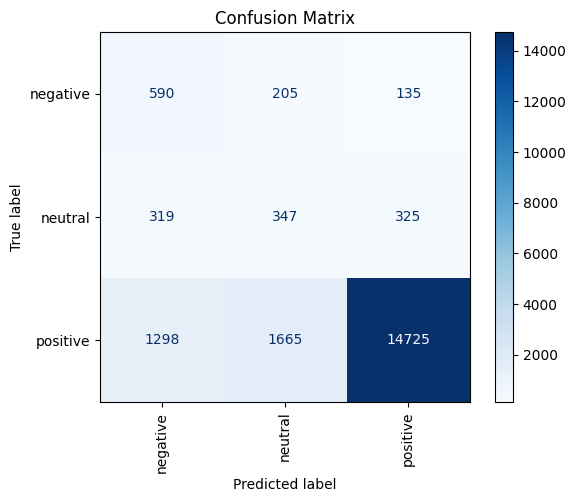

AttributeError: 'MultinomialNB' object has no attribute 'feature_importances_'

In [ ]:
# Set the best model and evaluate the models on the test data #TODO
nb_best = nb_cand_0
y_pred = nb_best.predict(x_test)
print(y_test[:20])
evaluate_model(nb_best, "NB-best", x_test, y_test, nb_best.get_params(), only_metrics=False)
calculate_OvR_roc_auc_score(nb_best, x_train, y_train, x_test, y_test, senti_labels)

## 3. SVM

### Training &  Tuning

In [33]:
# Create instances of the SVM model
svm_model = SVC()

In [34]:
# Define the parameter grid for grid search
svm_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': [0.1, 1, 'scale']
}

In [35]:
# Perform grid search
grid_search = GridSearchCV(svm_model, param_grid=svm_param_grid, cv=5)
grid_search.fit(x_train, y_train)

# Get the mean test scores and standard deviations of test scores for all parameter combinations
results_df = pd.DataFrame(grid_search.cv_results_)
sorted_results = results_df.sort_values(by=['mean_test_score', 'std_test_score'], ascending=[False, True])
top3_models = sorted_results[:3]
print_top3_models(top3_models)

### Evaluation

#### Validation set

In [ ]:
top3_params = top3_models['params'].values

# Evaluate the top 3 models on the validation set
svm_cand_0 = SVC(**top3_params[0])
svm_cand_0.fit(x_train, y_train)
evaluate_model(rf_cand_0, "Training-SVM-0", x_train, y_train, top3_params[0], only_metrics=True)
evaluate_model(rf_cand_0, "Validation-SVM-0", x_val, y_val, top3_params[0], only_metrics=True)

svm_cand_1 = SVC(**top3_params[1])
svm_cand_1.fit(x_train, y_train)
evaluate_model(rf_cand_1, "Training-SVM-1", x_train, y_train, top3_params[1], only_metrics=True)
evaluate_model(rf_cand_1, "Validation-SVM-1", x_val, y_val, top3_params[1], only_metrics=True)


svm_cand_2 = SVC(**top3_params[2])
svm_cand_2.fit(x_train, y_train)
evaluate_model(rf_cand_2, "Training-SVM-2", x_train, y_train, top3_params[2], only_metrics=True)
evaluate_model(rf_cand_2, "Validation-SVM-2", x_val, y_val, top3_params[2], only_metrics=True)

#### Test Set

In [ ]:
# Set the best model and evaluate the models on the test data #TODO
svm_best = svm_cand_0
y_pred = svm_best.predict(x_test)
evaluate_model(rf_best, "SVM-best", x_test, y_test, svm_best.get_params(), only_metrics=False)
calculate_OvR_roc_auc_score(svm_best, x_train, y_train, x_test, y_test, senti_labels)